In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# 1. Build a QCNN
### 1.1 Assemble circuits in a TensorFlow graph
TensorFlow Quantum (TFQ) provides layer classes designed for in-graph circuit construction. One example is the tfq.layers.AddCircuit layer that inherits from tf.keras.Layer. This layer can either prepend or append to the input batch of circuits, as shown in the following figure.



## 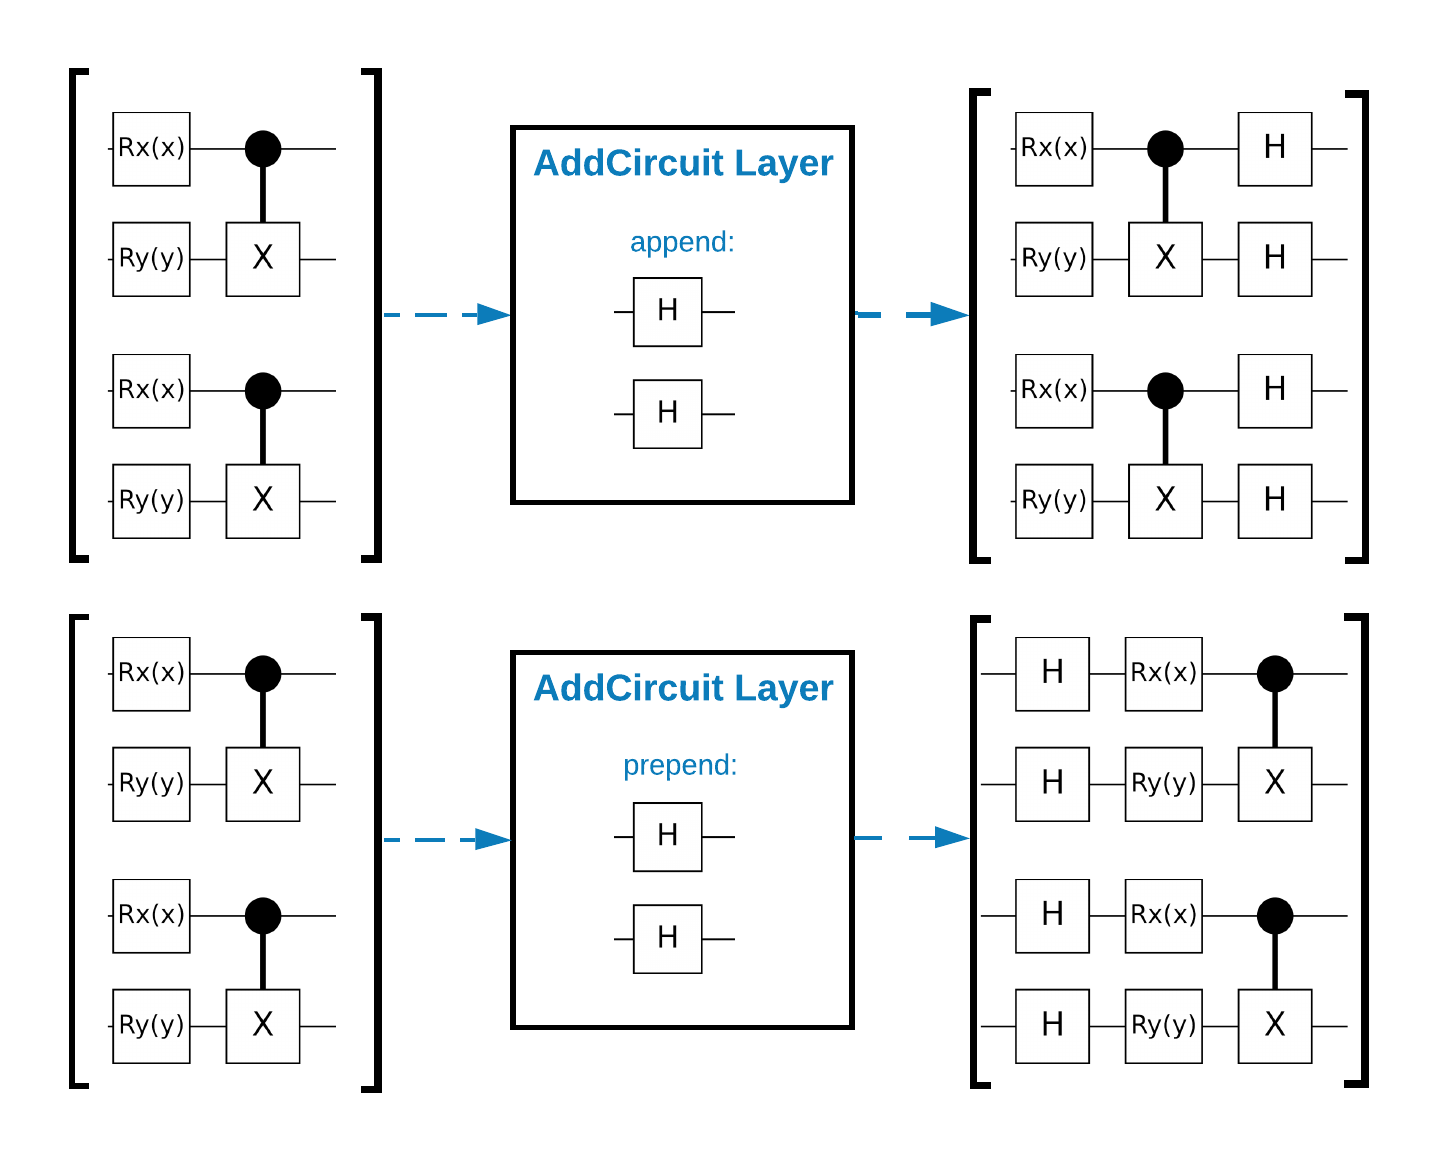

In [2]:
#This snippet uses this layer
qubit = cirq.GridQubit(0, 0)

circuit1 = cirq.Circuit(cirq.X(qubit))
circuit2 = cirq.Circuit(cirq.H(qubit))

#Convert to Tensor
input_circuit_tensor = tfq.convert_to_tensor([circuit1, circuit2])

#The Circuit which we want to append
y_circuit = cirq.Circuit(cirq.Y(qubit))

#Instantiate our layer
y_appender = tfq.layers.AddCircuit()

#Run the Circuit Tensor through the layer
output_circuit_tensor = y_appender(input_circuit_tensor, append=y_circuit)

In [3]:
#Examine the Input Tensor
print(tfq.from_tensor(input_circuit_tensor))

[cirq.Circuit([
    cirq.Moment(
        cirq.X(cirq.GridQubit(0, 0)),
    ),
])
 cirq.Circuit([
    cirq.Moment(
        cirq.H(cirq.GridQubit(0, 0)),
    ),
])]


In [4]:
#Output Tensor
print(tfq.from_tensor(output_circuit_tensor))

[cirq.Circuit([
    cirq.Moment(
        cirq.X(cirq.GridQubit(0, 0)),
    ),
    cirq.Moment(
        cirq.Y(cirq.GridQubit(0, 0)),
    ),
])
 cirq.Circuit([
    cirq.Moment(
        cirq.H(cirq.GridQubit(0, 0)),
    ),
    cirq.Moment(
        cirq.Y(cirq.GridQubit(0, 0)),
    ),
])]


While it is possible to run the examples below without using tfq.layers.AddCircuit, it's a good opportunity to understand how complex functionality can be embedded into TensorFlow compute graphs.

### 1.2 Problem overview
You will prepare a cluster state and train a quantum classifier to detect if it is "excited" or not. The cluster state is highly entangled but not necessarily difficult for a classical computer. For clarity, this is a simpler dataset than the one used in the paper.

For this classification task you will implement a deep MERA-like QCNN architecture since:

Like the QCNN, the cluster state on a ring is translationally invariant.
The cluster state is highly entangled.
This architecture should be effective at reducing entanglement, obtaining the classification by reading out a single qubit.

# 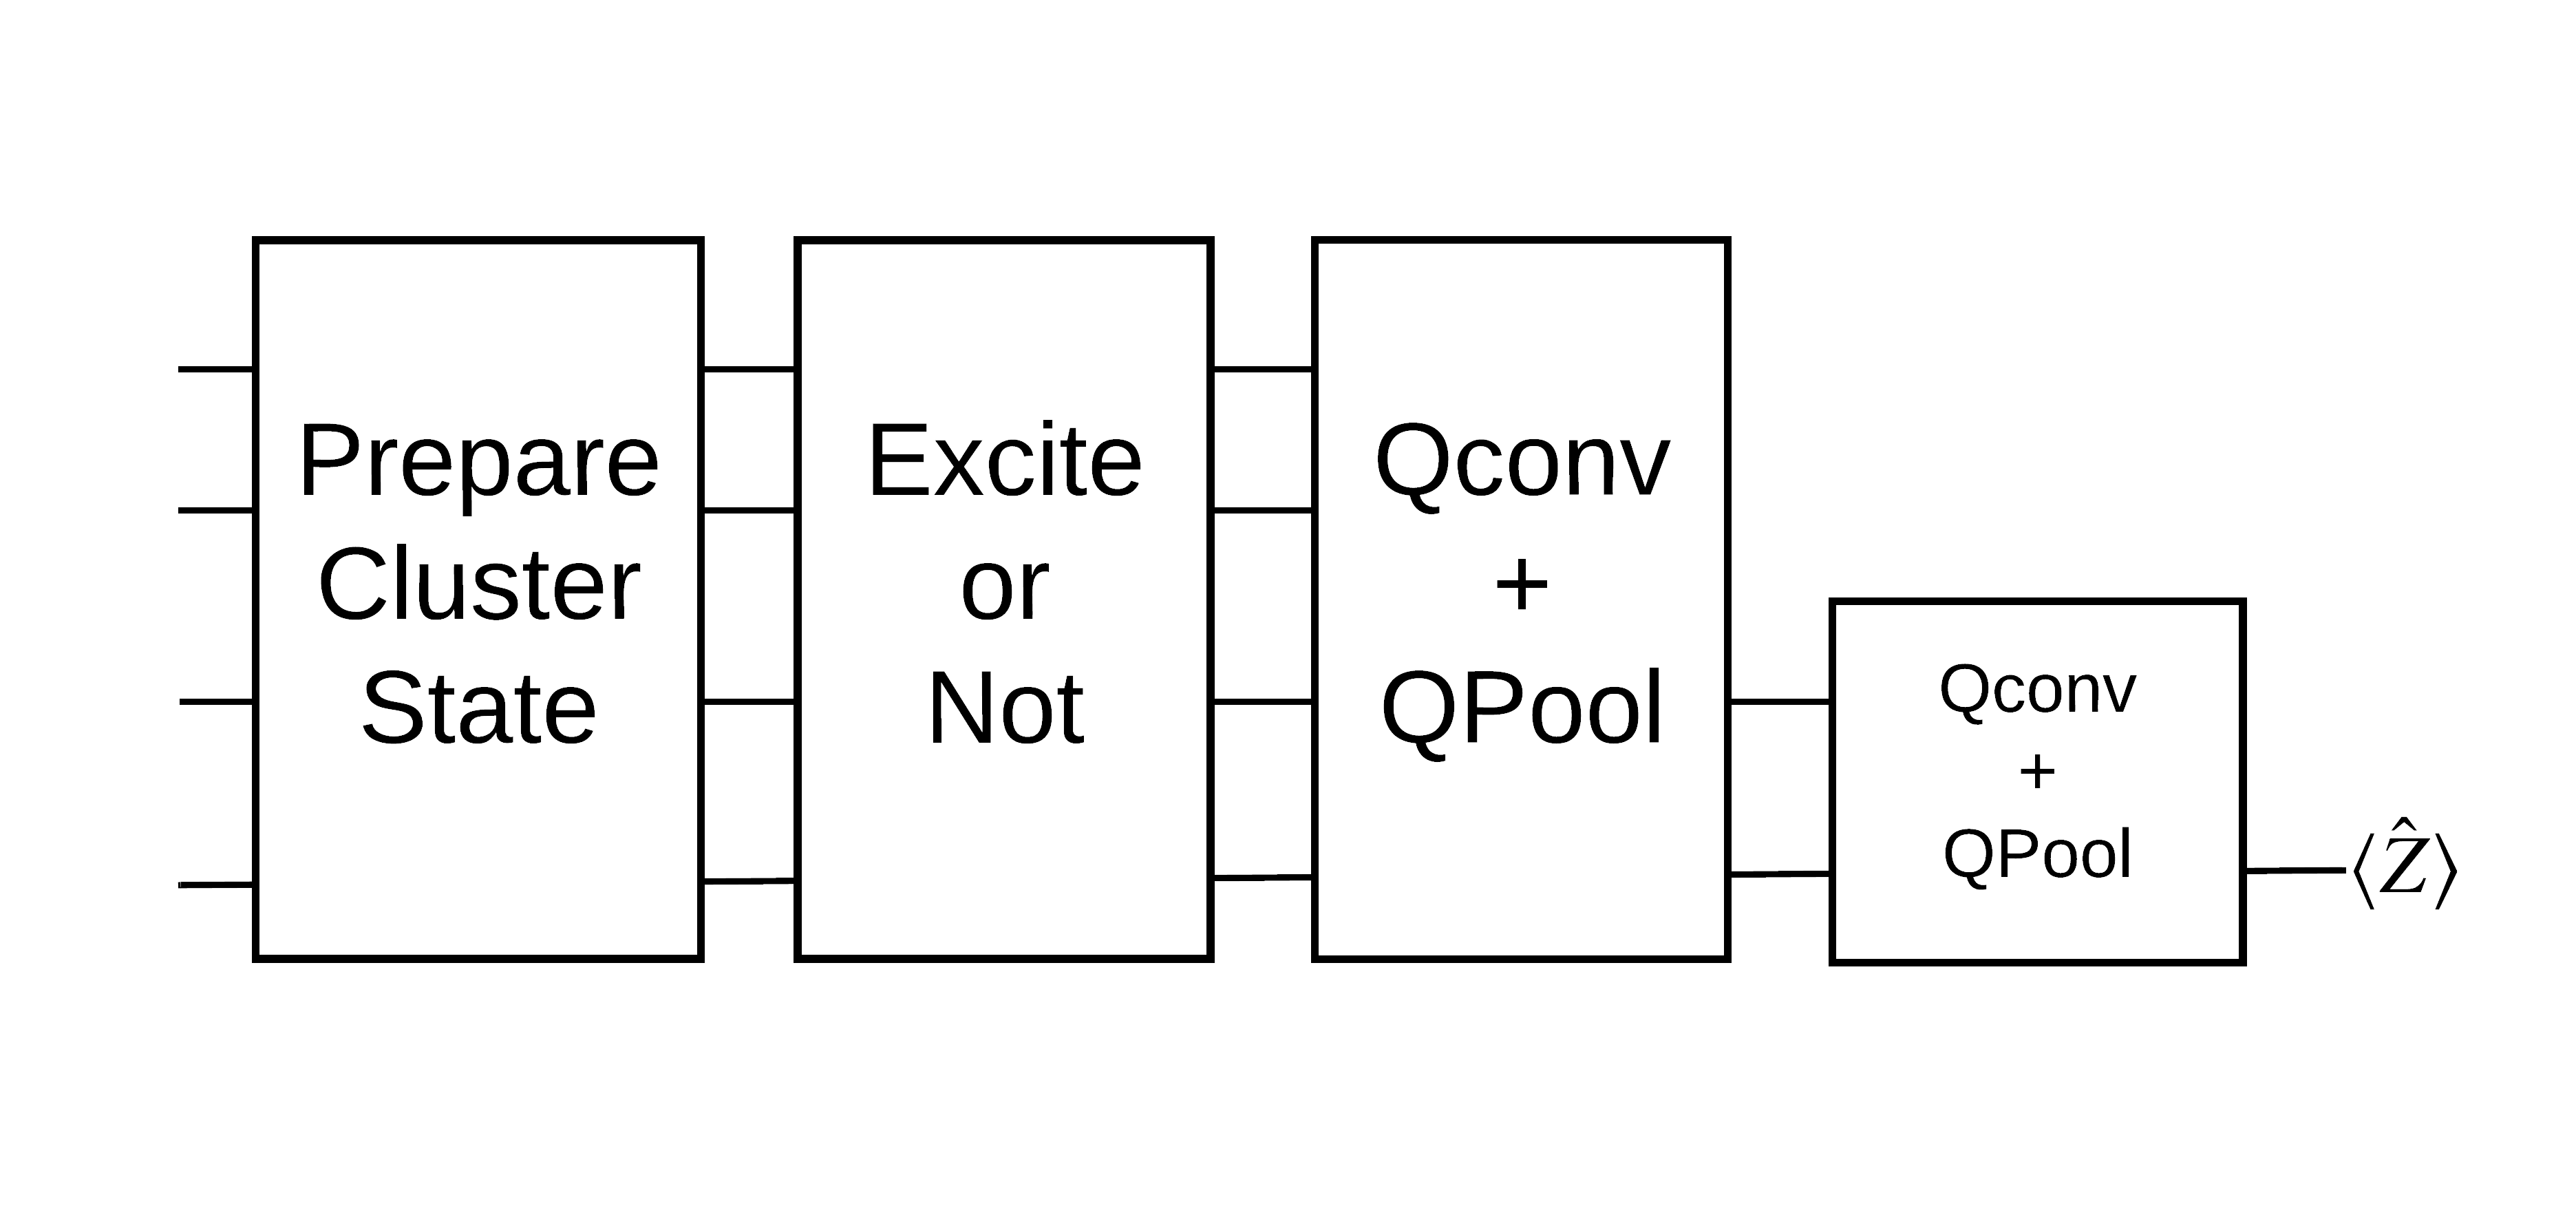

An "excited" cluster state is defined as a cluster state that had a cirq.rx gate applied to any of its qubits. Qconv and QPool are discussed later in this tutorial.

### 1.3 Building blocks for TensorFlow

# 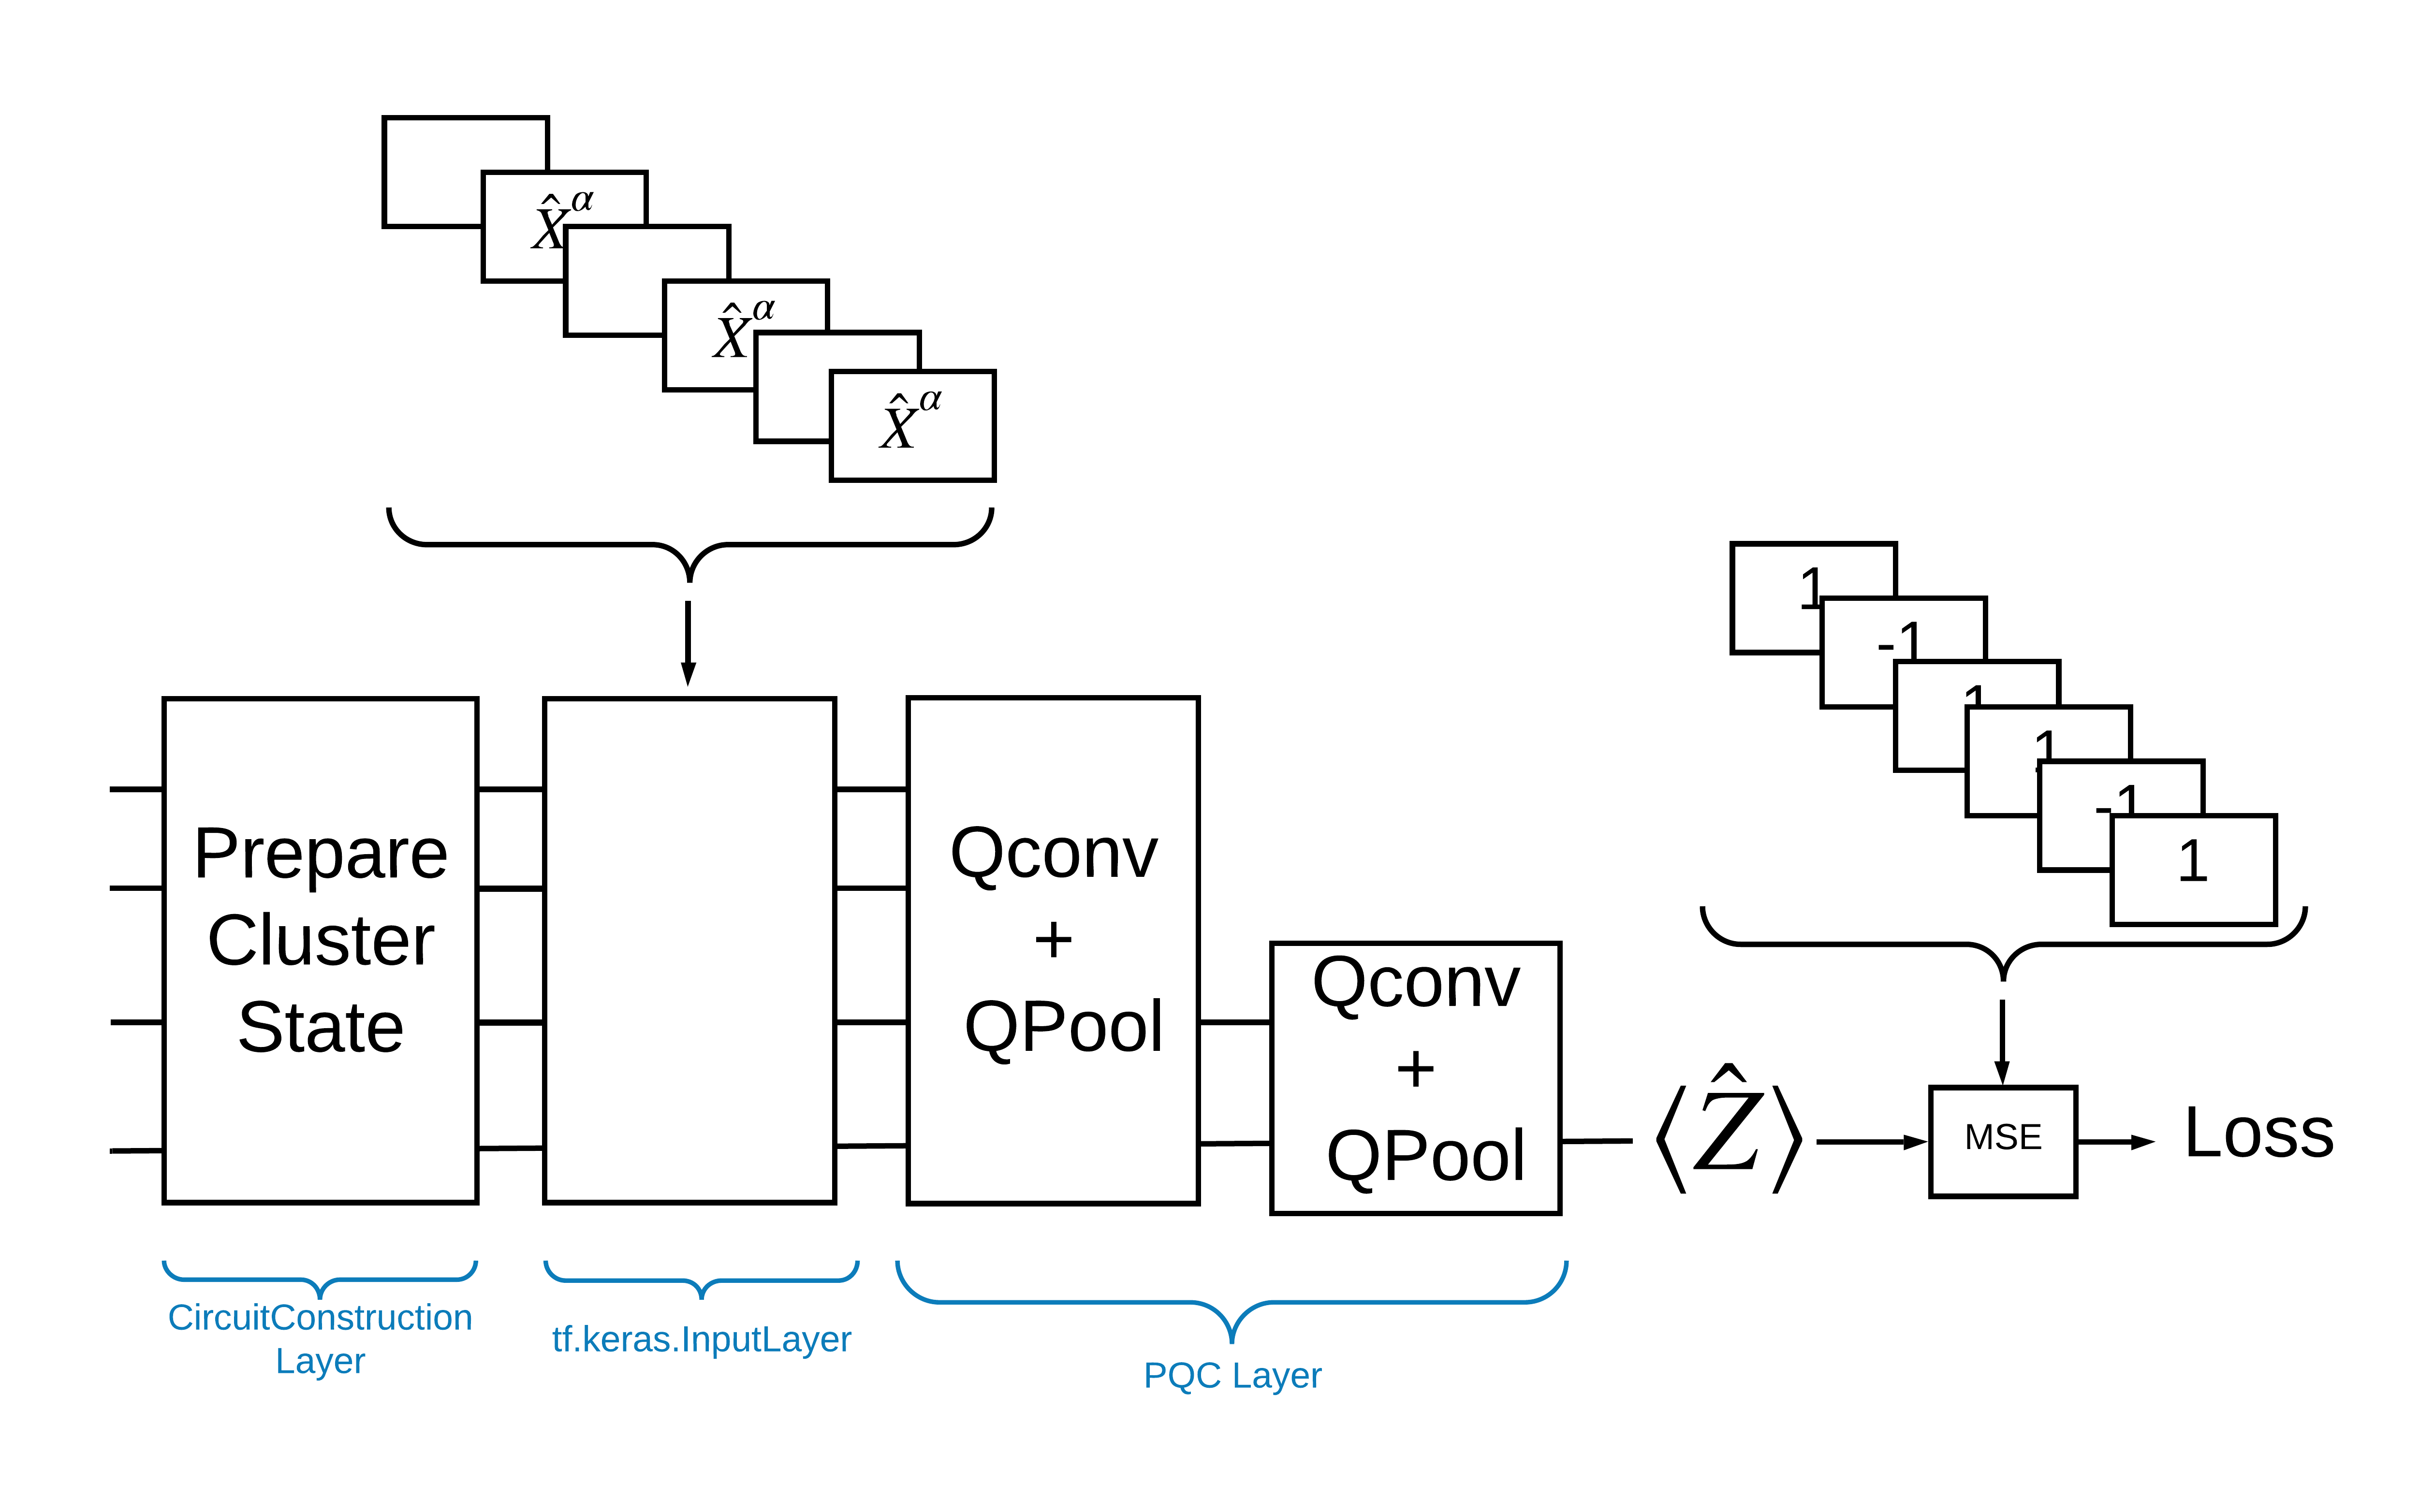

One way to solve this problem with TensorFlow Quantum is to implement the following:

1.The input to the model is a circuit tensor—either an empty circuit or an X gate on a particular qubit indicating an excitation.

2.The rest of the model's quantum components are constructed with tfq.layers.AddCircuit layers.

3.For inference a tfq.layers.PQC layer is used. This reads <Z^>  and compares it to a label of 1 for an excited state, or -1 for a non-excited state.


### 1.4 Data
Before building your model, you can generate your data. In this case it's going to be excitations to the cluster state (The original paper uses a more complicated dataset). Excitations are represented with cirq.rx gates. A large enough rotation is deemed an excitation and is labeled 1 and a rotation that isn't large enough is labeled -1 and deemed not an excitation

In [5]:
def generate_data(qubits):
    """Generate training and testing data"""
    n_rounds = 20 #Produces n_rounds * n_qubits datapoints
    excitations = []
    labels = []
    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            labels.append(1 if (-np.pi/2) <= rng <= (np.pi/2) else -1)
    
    split_ind = int(len(excitations) * 0.7)
    train_excitations = excitations[:split_ind]
    test_excitations = excitations[split_ind:]
    
    train_labels = labels[:split_ind]
    test_labels = labels[split_ind:]
    
    return tfq.convert_to_tensor(train_excitations), np.array(train_labels), tfq.convert_to_tensor(test_excitations), np.array(test_labels)

In [6]:
#You can see that just like with regular machine learning you create a training and testing set to use to benchmark the model. 
#You can quickly look at some datapoints with:
sample_points, sample_labels, _, __ = generate_data(cirq.GridQubit.rect(1, 4))
print('Input: ', tfq.from_tensor(sample_points)[0], 'Output: ', sample_labels[0])
print('Input: ', tfq.from_tensor(sample_points)[1], 'Output: ', sample_labels[1])

Input:  (0, 0): ───Rx(-0.324π)─── Output:  1
Input:  (0, 1): ───Rx(-0.907π)─── Output:  -1


### 1.5 Define layers
Now define the layers shown in the figure above in TensorFlow.

#### 1.5.1 Cluster state
The first step is to define the cluster state using Cirq, a Google-provided framework for programming quantum circuits. Since this is a static part of the model, embed it using the tfq.layers.AddCircuit functionality. 

In [7]:
def cluster_state(bits):
    """Returns a cluster state on the qubits in `bits`. """
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

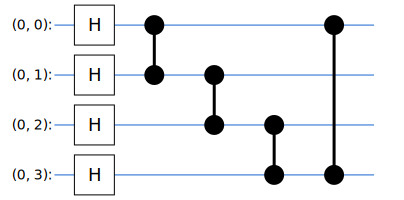

In [8]:
#Display a Cluster State Circuit for a rect of cirq.GridQubit
SVGCircuit(cluster_state(cirq.GridQubit.rect(1, 4)))

#### 1.5.2 QCNN layers
Define the layers that make up the model using the Cong and Lukin QCNN paper. There are a few prerequisites:

The one- and two-qubit parameterized unitary matrices from the Tucci paper.
A general parameterized two-qubit pooling operation.
 

In [18]:
def one_qubit_unitary(bit, symbols):
    """Make a Circuit enacting a rotation of the bloch sphere about the X, Y, Z axis, that depends on the values in `symbols.`"""
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2]
    )

def two_qubit_unitary(bits, symbols):
    """Makes a Cirq Circuit circuit that creates an arbitrary two qubit unitary"""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[0], symbols[12:])
    return circuit


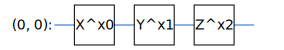

In [19]:
SVGCircuit(one_qubit_unitary(cirq.GridQubit(0, 0), sympy.symbols('x0:3')))

In [21]:
#A two qubit circuit display
SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(0, 0), sympy.symbols('x0:12')))

IndexError: list index out of range